# Explore results

In this notebook, I explore the similarity results in the search for COVID-19 candidates based on existing literature data.

In [7]:
%matplotlib inline
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import collections
import h5py
import pandas as pd
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as patches
from chemicalchecker.util.plot.diagnosticsplot import set_style, coord_color
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde, fisher_exact
from MulticoreTSNE import MulticoreTSNE as TSNE
from tqdm import tqdm
set_style()

## Literature data

This is how the literature data looks like once pulled from the Google Spreadsheet and processed.

In [18]:
OUTPATH = "../web/static/images/docu"
SIMTYPE = "cc"

In [19]:
df_lit = pd.read_csv("../web/data/df_lit_%s.csv" % SIMTYPE, sep="\t")
df_lit

,InChIKey,Name,Level,Evidence,MoA
0,IWUCXVSUMQZMFG-AFCXAGJDSA-N,Levovirin,4,Clinics COVID19,RNA trans./rep.
1,KCFYEAOKVJSACF-UHFFFAOYSA-N,Umifenovir,4,Clinics COVID19,Virus entry
2,KJHKTHWMRKYKJE-SUGCFTRWSA-N,Lopinavir,4,Clinics COVID19,Protease inh.
3,LUKZNWIVRBCLON-GXOBDPJESA-N,Ciclesonide,4,Clinics COVID19,Immunomodulator
4,UYNVMODNBIQBMV-UHFFFAOYSA-N,Ifenprodil,4,Clinics COVID19,Immunomodulator
...,...,...,...,...,...
193,UVYVLBIGDKGWPX-XJVHMSFUSA-N,Digitonin,0,Text mining,Not given
194,WTDWVLJJJOTABN-UHFFFAOYSA-N,Nesbuvir,0,Text mining,Not given
195,XRQDFNLINLXZLB-CKIKVBCHSA-N,Peramivir,0,Text mining,Not given
196,ZPEMEBKNEHMBJS-UHFFFAOYSA-N,Chembl3125026,0,Text mining,Not given


In [38]:
evids = ["Failed in clinics", "Text mining", "Computational", "Preclinical", "Clinics", "Clinics COVID19"]
moas  = ["Unknown", "Host factor", "Virus entry", "Protease inh.", "RNA trans./rep.", "Immunomodulator"]

eabb = ["Fail", "TM", "Comp", "Pre", "Clin", "CoV"]
mabb = ["UNK", "HF", "VE", "PI", "RNA", "IM"]

cap = df_lit.shape[0]/3

def lit_barplot(ax, df, column):
    counts = collections.defaultdict(int)
    x = []
    y = []
    if column == "Evidence":
        cats = evids
    else:
        cats = moas
    z = []
    for i, cat in enumerate(cats):
        x += [i]
        y += [len(df[df[column] == cat])]
        z += [cat]
    norm = mpl.colors.Normalize(vmin=0,vmax=cap)
    cmap = cm.get_cmap("Spectral")
    color = cmap(norm(y))
    if column == "Evidence":
        for i in range(0, len(x)):
            rect = patches.Rectangle((x[i]-0.2, 0), 0.5, y[i], facecolor=color[i], edgecolor="black", lw=1)
            ax.add_patch(rect)
        ax.set_xticks(x)
        ax.set_xticklabels(eabb)
        ax.set_ylabel("Counts")
        ax.set_ylim(0, np.max(y)*1.05)
        ax.set_xlim(-0.5, len(x)-0.5)
        ax.set_title("Evidence")
    else:
        for i in range(0, len(x)):
            rect = patches.Rectangle((0, x[i]-0.2), y[i], 0.5, facecolor=color[i], edgecolor="black", lw=1)
            ax.add_patch(rect)
        ax.set_yticks(x)
        ax.set_yticklabels(mabb)
        ax.set_xlabel("Counts")
        ax.set_xlim(0, np.max(y)*1.05)
        ax.set_ylim(-0.5, len(x)-0.5)
        ax.set_title("MoA")
    
def lit_overlaps(ax, df):
    x = []
    y = []
    z = []
    c = []
    for i, e in enumerate(evids):
        for j, m in enumerate(moas):
            a  = len(df[(df["Evidence"] == e) & (df["MoA"] == m)])
            b  = len(df[(df["Evidence"] == e) | (df["MoA"] == m)])
            z += [a/b]
            c += [a]
            x += [i]
            y += [j]
    x = np.array(x)
    y = np.array(y)
    norm = mpl.colors.Normalize(vmin=0,vmax=cap)
    cmap = cm.get_cmap("Spectral")
    c = cmap(norm(c))
    z = np.array(z)
    ax.scatter(x,y,color=c,s=z*2000, edgecolor="black", lw=0.8)
    ax.set_xticks(sorted(set(x)))
    ax.set_yticks(sorted(set(y)))
    ax.set_xticklabels(eabb)
    ax.set_yticklabels(mabb)
    ax.set_xlim(-0.5, len(set(x))-0.5)
    ax.set_ylim(-0.5, len(set(y))-0.5)
    ax.set_title("Overlap")

def lit_nn(ax):
    with h5py.File("../web/data/dist_%s.h5" % SIMTYPE, "r") as hf:
        V = hf["V_lit_trim"][:]
    nn = NearestNeighbors(6)
    nn.fit(V)
    dist = nn.kneighbors(V)[0][:,1:]
    ks = [1,2,3,4,5]
    norm = mpl.colors.Normalize(1,5)
    cmap = cm.get_cmap("Spectral")
    color = cmap(norm(ks))
    for i,k in enumerate(ks):
        scores = dist[:,i]
        kernel = gaussian_kde(scores)
        x = np.linspace(0, np.max(scores), 1000)
        y = kernel(x)
        ax.plot(x,y,color=color[i],label="k=%d" % (k))
    ax.set_title("NN intra literature")
    ax.set_xlabel("Distance")
    ax.set_ylabel("Density")
    ylim = ax.get_ylim()
    ax.set_ylim(0,ylim[1])
    ax.legend()


In [ ]:
with h5py.File("../web/data/dist_%s.h5" % SIMTYPE, "r") as hf:
    print(hf.keys())
    evid = hf["evi_cols"][:]
    ranks = hf["ranks"][:]
    ranks_w = hf["ranks_w"][:]
    support = hf["support"][:]

In [49]:
evi_colordict = {
    0: coord_color("E"),
    1: coord_color("A"),
    2: coord_color("B"),
    3: coord_color("C"),
    4: coord_color("D")
}
moa_colordict = {
    0: "gray",
    1: coord_color("E"),
    2: coord_color("A"),
    3: coord_color("B"),
    4: coord_color("C"),
    5: coord_color("D")        
}

In [50]:
def image(ax, ranks, evid, max_n):
    idxs = np.argsort(-support)
    M = ranks[idxs][:max_n]
    idxs = np.argsort(-evid)
    M = M[:,idxs]
    evid = evid[idxs]
    evid[evid < 0] = 0
    ax.set_xlabel("Literature drugs")
    ax.set_ylabel("Candidates (ranked by support)")
    x = np.array([i for i in range(0, M.shape[1])])
    y = np.array([j for j in range(0, M.shape[0])])
    norm = mpl.colors.Normalize(vmin=0,vmax=3)
    cmaps = {4: cm.get_cmap("Greens"),
             3: cm.get_cmap("Blues"),
             2: cm.get_cmap("Purples"),
             1: cm.get_cmap("Reds"),
             0: cm.get_cmap("Oranges")}
    for j in tqdm(range(0, M.shape[1])):
        r = M[:,j]
        ys = y[r > 0]
        cmap = cmaps[evid[j]]
        color = cmap(norm(r[r>0]))
        ax.scatter([j]*len(ys), ys, color=color, s=0.2)
    ax.axvline(np.sum(evid>=4)-0.5, color=evi_colordict[4], lw=1, label="CoV")
    ax.axvline(np.sum(evid>=3)-0.5, color=evi_colordict[3], lw=1, label="Clin")
    ax.axvline(np.sum(evid>=2)-0.5, color=evi_colordict[2], lw=1, label="Pre")
    ax.axvline(np.sum(evid>=1)-0.5, color=evi_colordict[1], lw=1, label="Comp")
    ax.axvline(np.sum(evid>=0)+0.5, color=evi_colordict[0], lw=1, label="TM")
    ax.set_ylim(M.shape[0], 0)
    ax.set_xlim(0, M.shape[1])
    ax.set_title("Similarity matrix")
    ax.legend()

100%|██████████| 198/198 [00:00<00:00, 332.60it/s]


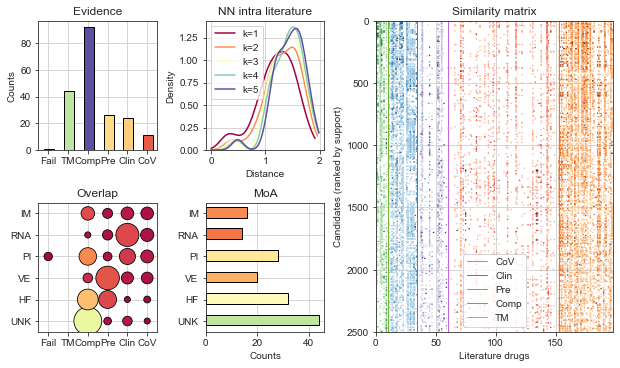

In [52]:
fig = plt.figure(constrained_layout=True, figsize=(8.5,5))
gs = fig.add_gridspec(2, 4)
ax = fig.add_subplot(gs[0,0])
lit_barplot(ax, df_lit, column="Evidence")
ax = fig.add_subplot(gs[1,1])
lit_barplot(ax, df_lit, column="MoA")
ax = fig.add_subplot(gs[0,1])
lit_nn(ax)
ax = fig.add_subplot(gs[1,0])
lit_overlaps(ax, df_lit)
ax = fig.add_subplot(gs[2:])
image(ax, ranks, evid, 2500)
plt.savefig(os.path.join(OUTPATH, "literature_%s.png" % SIMTYPE), dpi=300)

## Projections of literature data

In [55]:
with h5py.File("../web/data/dist_fp.h5", "r") as hf:
    V_can_trim = hf["V_can_trim"][:]
    iks_can_trim = hf["iks_can_trim"][:]
    V_lit      = hf["V_lit_trim"][:]
    iks_lit    = hf["cols"][:]
    evi_lit    = hf["evi_cols"][:]
    moa_lit    = hf["moa_cols"][:]
    V = np.vstack([V_lit, V_can_trim])
    
mani = TSNE()
Pcan = mani.fit_transform(V)

In [56]:
with h5py.File("../web/data/dist_fp.h5", "r") as hf:
    V_rnd_trim = hf["V_rnd_trim"][:]
    iks_can_trim = hf["iks_rnd_trim"][:]
    V = np.vstack([V_lit, V_rnd_trim])
    
mani = TSNE()
Prnd = mani.fit_transform(V)

In [64]:
def projection_moa(ax, P, title, legend):
    P_lit = P[:len(moa_lit)]
    P_can = P[len(moa_lit):]
    ax.scatter(P_can[:,0], P_can[:,1], color="lightgray", s=1)
    moa_colors = {0: "gray",
                  1: coord_color("A"),
                  2: coord_color("B"),
                  3: coord_color("C"),
                  4: coord_color("D"),
                  5: coord_color("E")}
    moa_legend = {0: "UNK",
                  1: "HF",
                  2: "VF",
                  3: "PI",
                  4: "RNA",
                  5: "IM"}
    for c in [0, 1, 2, 3, 4, 5]:
        mask = moa_lit == c
        ax.scatter(P_lit[mask,0], P_lit[mask,1], color=moa_colors[c], edgecolor="white", label=moa_legend[c])
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title(title)
    if legend:
        ax.legend()
    
def projection_evi(ax, P, title, legend):
    evi_lit[evi_lit < 0] = 0
    P_lit = P[:len(evi_lit)]
    P_can = P[len(evi_lit):]
    ax.scatter(P_can[:,0], P_can[:,1], color="lightgray", s=1)
    evi_colors = {0: coord_color("A"),
                  1: coord_color("B"),
                  2: coord_color("C"),
                  3: coord_color("D")}
    evi_legend = {0: "Comp",
                  1: "Preclin",
                  2: "Clin",
                  3: "COV19"}
    for c in [0, 1, 2, 3]:
        mask = evi_lit == c
        ax.scatter(P_lit[mask,0], P_lit[mask,1], color=evi_colors[c], edgecolor="white", label=evi_legend[c])
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title(title)
    if legend:
        ax.legend()

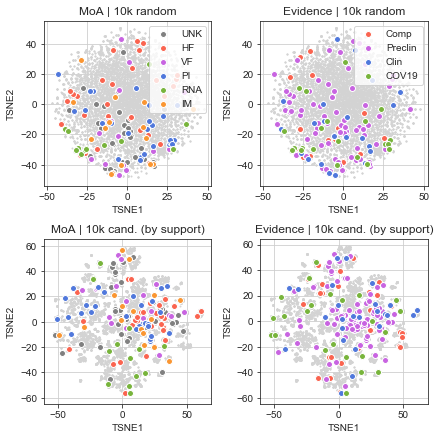

In [65]:
fig = plt.figure(constrained_layout=True, figsize=(6,6))
gs = fig.add_gridspec(2,2)
ax = fig.add_subplot(gs[0,0])
projection_moa(ax, Prnd, title="MoA | 10k random", legend=True)
ax = fig.add_subplot(gs[0,1])
projection_evi(ax, Prnd, title="Evidence | 10k random", legend=True)
ax = fig.add_subplot(gs[1,0])
projection_moa(ax, Pcan, title="MoA | 10k cand. (by support)", legend=False)
ax = fig.add_subplot(gs[1,1])
projection_evi(ax, Pcan, title="Evidence | 10k cand. (by support)", legend=False)
plt.savefig(os.path.join(OUTPATH, "projections_%s.png" % SIMTYPE), dpi=300)

## ATC analysis

In [8]:
def load_df(simtype, evidence, moa):
    if evidence is None or evidence < 0:
        evi_suf = "eviall"
    else:
        evi_suf = "evi%d" % evidence
    if moa is None:
        moa_suf = "moaall"
    else:
        moa_suf = "moa%d" % moa
    fn = "../web/data/df_cand_%s_%s_%s.csv" % (simtype, evi_suf, moa_suf)
    df = pd.read_csv(fn, sep="\t")
    return df


In [52]:
def atc_test_old(ax, simtype="cc", atc_level="B", top=100, exclude_self=True):
    with h5py.File("../web/data/dist_%s.h5" % simtype, "r") as hf:
        iks_lit = hf["cols"][:]
        iks_can = hf["rows"][:]
        support = hf["support"][:]
    idxs = np.argsort(-support)
    support = support[idxs]
    iks_can = iks_can[idxs]
    pos_iks = iks_can[:top]
    neg_iks = iks_can[top:]
    def get_atcs(level="B"):
        atcs = collections.defaultdict(set)
        with open("../data/atcs.tsv", "r") as f:
            for l in f:
                l = l.rstrip("\n").split("\t")
                atcs[l[0].split("-")[0]].update([x.split(":")[1] for x in l[1].split(",") if "%s:" % atc_level in x])
        return atcs
    atcs = get_atcs()    
    atc_descr = {
        "A": "Alim. tract & Met.",
        "B": "Blood etc.",
        "C": "Cardiovascular",
        "D": "Dermatol.",
        "G": "Genitourinary etc.",
        "H": "Syst. horm",
        "J": "Antiinfectives",
        "L": "Antineoplastic",
        "M": "Musculoskeletal",
        "N": "Nervous",
        "P": "Antiparasitic",
        "R": "Respiratory",
        "S": "Sensory organs",
        "V": "Various"
    }
    descr_sort = sorted([x for x in atc_descr.keys()])
    norm = mpl.colors.Normalize(vmin=0,vmax=len(atc_descr)-1)
    cmap = cm.get_cmap("Spectral")
    universe = set(atcs.keys())
    if exclude_self:
        universe.difference(set([x.split("-")[0] for x in iks_lit]))
    Pos = set()
    Neg = set()
    for ik in pos_iks:
        ik = ik.split("-")[0]
        if ik not in universe:
            continue
        Pos.update([ik])
    for ik in neg_iks:
        ik = ik.split("-")[0]
        if ik not in universe:
            continue
        Neg.update([ik])
    Neg = Neg.difference(Pos)
    universe = universe.intersection(Pos.union(Neg))
    atc_sets = collections.defaultdict(set)
    for k,v in atcs.items():
        if k not in universe:
            continue
        for x in v:
            atc_sets[x].update([k])
    atc_cats = sorted(atc_sets.keys())
    x = []
    y = []
    enriched = []
    for atc in atc_cats:
        v = atc_sets[atc]
        A = len(v.intersection(Pos))
        B = len(Pos) - A
        C = len(v.intersection(Neg))
        D = len(universe) - (A+B+C)
        odds, pval = fisher_exact([[A,B],[C,D]], alternative="greater")
        x += [odds]
        y += [-np.log10(pval)]
    x = np.array(x)
    y = np.array(y)
    labs = np.array(atc_cats)
    idxs = np.argsort(-y)
    y = y[idxs][:25]
    labs = labs[idxs][:25]
    color = cmap(norm([descr_sort.index(l[0]) for l in labs]))
    x = x[idxs][:25]
    ax.scatter([i for i in range(0, len(y))], y, color="black")
    ax.set_title("ATC codes in top %d" % top)
    ax.set_ylabel("-log10 P-value")
    ax.set_xticks([i for i in range(0, len(y))])
    ax.set_xticklabels(labs, rotation=45)
    return enriched

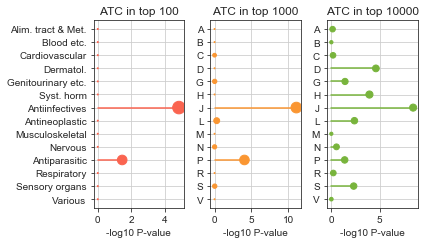

In [50]:
def atc_test(ax, simtype="cc", atc_level="B", top=100, exclude_self=True, yaxis=True):
    with h5py.File("../web/data/dist_%s.h5" % simtype, "r") as hf:
        iks_lit = hf["cols"][:]
        iks_can = hf["rows"][:]
        support = hf["support"][:]
    idxs = np.argsort(-support)
    support = support[idxs]
    iks_can = iks_can[idxs]
    pos_iks = iks_can[:top]
    neg_iks = iks_can[top:]
    def get_atcs(level="B"):
        atcs = collections.defaultdict(set)
        with open("../data/atcs.tsv", "r") as f:
            for l in f:
                l = l.rstrip("\n").split("\t")
                atcs[l[0].split("-")[0]].update([x.split(":")[1] for x in l[1].split(",") if "%s:" % atc_level in x])
        return atcs
    atcs = get_atcs()    
    atc_descr = {
        "A": "Alim. tract & Met.",
        "B": "Blood etc.",
        "C": "Cardiovascular",
        "D": "Dermatol.",
        "G": "Genitourinary etc.",
        "H": "Syst. horm",
        "J": "Antiinfectives",
        "L": "Antineoplastic",
        "M": "Musculoskeletal",
        "N": "Nervous",
        "P": "Antiparasitic",
        "R": "Respiratory",
        "S": "Sensory organs",
        "V": "Various"
    }
    descr_sort = sorted([x for x in atc_descr.keys()])
    norm = mpl.colors.Normalize(vmin=0,vmax=len(atc_descr)-1)
    cmap = cm.get_cmap("Spectral")
    universe = set(atcs.keys())
    if exclude_self:
        universe.difference(set([x.split("-")[0] for x in iks_lit]))
    Pos = set()
    Neg = set()
    for ik in pos_iks:
        ik = ik.split("-")[0]
        if ik not in universe:
            continue
        Pos.update([ik])
    for ik in neg_iks:
        ik = ik.split("-")[0]
        if ik not in universe:
            continue
        Neg.update([ik])
    Neg = Neg.difference(Pos)
    universe = universe.intersection(Pos.union(Neg))
    atc_sets = collections.defaultdict(set)
    for k,v in atcs.items():
        if k not in universe:
            continue
        for x in v:
            atc_sets[x].update([k])
    atc_cats = sorted(atc_sets.keys())
    x = []
    y = []
    enriched = []
    for atc in atc_cats:
        v = atc_sets[atc]
        A = len(v.intersection(Pos))
        B = len(Pos) - A
        C = len(v.intersection(Neg))
        D = len(universe) - (A+B+C)
        odds, pval = fisher_exact([[A,B],[C,D]], alternative="greater")
        x += [odds]
        y += [-np.log10(pval)]
    x = np.array(x)
    y = np.array(y)
    labs = np.array(atc_cats)
    x_ = [i for i in range(0, len(y))]
    if top == 100:
        color = coord_color("A")
    if top == 1000:
        color = coord_color("E")
    if top == 10000:
        color = coord_color("D")
    ax.scatter(y, x_, s=np.sqrt(x*1000)+1, color=color)
    for i in range(0, len(y)):
        ax.plot([0, y[i]], [x_[i], x_[i]], color=color)
    ax.set_yticks(x_)
    if yaxis:
        ax.set_yticklabels([atc_descr[l] for l in labs])
    else:
        ax.set_yticklabels(labs)
    ax.set_xlabel("-log10 P-value")
    ax.set_title("ATC in top %d" % top)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[1], ylim[0])
    
fig, axs = plt.subplots(1,3, figsize=(6, 3.5))
axs = axs.flatten()
atc_test(axs[0], simtype="cc", atc_level="A", top=100, yaxis=True)
atc_test(axs[1], simtype="cc", atc_level="A", top=1000, yaxis=False)
atc_test(axs[2], simtype="cc", atc_level="A", top=10000, yaxis=False)
plt.tight_layout()
plt.savefig("../web/static/images/docu/atc_cc.png", dpi=300)

## Significance

In [79]:
def loo_support_evi(evi_level, ranks_w, rows, cols, evi_cols):
    cols_idxs = dict((k,i) for i,k in enumerate(cols))
    support = []
    mask = evi_cols >= evi_level
    for i in tqdm(range(0, len(rows))):
        r = ranks_w[i]
        if rows[i] in cols_idxs:
            r[cols_idxs[rows[i]]] = 0
        support += [np.sum(r[mask])]
    return np.array(support)
        
def evidence_binarizer(evi_level, evi_rows):
    evi = np.array(evi_rows)
    evi[evi >= evi_level] = 10
    evi[evi < evi_level] = 0
    evi[evi == 10] = 1
    return evi
    
def get_supp_evi(evi_level_row, evi_level_col, ranks_w, rows, cols, evi_rows, evi_cols):
    true = evidence_binarizer(evi_level_row, evi_rows)
    pred = loo_support_evi(evi_level_col, ranks_w, rows, cols, evi_cols)
    return true, pred

def randomize_sum(true, pred):
    v = np.sum(pred[true==1])
    rands = []
    true_ = np.array(true)
    for _ in tqdm(range(0, 1000)):
        np.random.shuffle(true_)
        rands += [np.sum(pred[true_==1])]
    return v, rands

def empirical_plot(ax, val, rands, evid_level_row, evid_level_col):
    norm = mpl.colors.Normalize(vmin=-4,vmax=4)
    cmap = cm.get_cmap("coolwarm")
    color = cmap(norm(evid_level_row-evid_level_col))    
    rand_counts = collections.defaultdict(int)
    for r in rands:
        rand_counts[r] += 1
    x = []
    y = []
    for k,v in rand_counts.items():
        x += [k]
        y += [v]
    ax.scatter(x,y,color=color,s=4)
    ax.axvline(val, color=color)
    ax.set_xlim(0, np.max([np.max(x), val])*1.1)
    ax.set_ylim(0, np.max(y)*1.1)
    ax.set_xlabel("Sum of supports")
    ax.set_ylabel("Density")
    title = "Cand: %d CoV: %d" % (evid_level_row, evid_level_col)
    ax.set_title(title)
    ax.axes.get_yaxis().set_visible(False)

def empirical_support(ax, evid_level_row, evid_level_col, ranks_w, rows, cols, evi_rows, evi_cols):
    true, pred = get_supp_evi(evid_level_row, evid_level_col, ranks_w, rows, cols, evi_rows, evi_cols)
    v, rands = randomize_sum(true, pred)
    empirical_plot(ax, v, rands, evid_level_row, evid_level_col)
    


 49%|████▉     | 491/1000 [00:00<00:00, 4907.17it/s]

0 0


 50%|█████     | 502/1000 [00:00<00:00, 5010.53it/s]

0 1


 50%|█████     | 501/1000 [00:00<00:00, 5008.44it/s]

0 2


 50%|█████     | 500/1000 [00:00<00:00, 4998.16it/s]

0 3


 48%|████▊     | 485/1000 [00:00<00:00, 4843.62it/s]

0 4


 50%|█████     | 502/1000 [00:00<00:00, 5015.14it/s]

1 0


 47%|████▋     | 468/1000 [00:00<00:00, 4677.28it/s]

1 1


 49%|████▉     | 492/1000 [00:00<00:00, 4912.20it/s]

1 2


 49%|████▉     | 494/1000 [00:00<00:00, 4934.63it/s]

1 3


 49%|████▉     | 493/1000 [00:00<00:00, 4920.90it/s]

1 4


 49%|████▉     | 494/1000 [00:00<00:00, 4932.90it/s]

2 0


 49%|████▉     | 491/1000 [00:00<00:00, 4908.06it/s]

2 1


 50%|█████     | 504/1000 [00:00<00:00, 5038.48it/s]

2 2


 51%|█████     | 507/1000 [00:00<00:00, 5068.82it/s]

2 3


 49%|████▉     | 491/1000 [00:00<00:00, 4907.77it/s]

2 4


 49%|████▉     | 490/1000 [00:00<00:00, 4893.74it/s]

3 0


 49%|████▉     | 494/1000 [00:00<00:00, 4935.79it/s]

3 1


 49%|████▊     | 486/1000 [00:00<00:00, 4856.21it/s]

3 2


 51%|█████     | 510/1000 [00:00<00:00, 5092.10it/s]

3 3


 48%|████▊     | 479/1000 [00:00<00:00, 4783.47it/s]

3 4


 51%|█████     | 508/1000 [00:00<00:00, 5075.66it/s]

4 0


 49%|████▉     | 492/1000 [00:00<00:00, 4916.98it/s]

4 1


 51%|█████     | 508/1000 [00:00<00:00, 5076.17it/s]

4 2


 50%|████▉     | 496/1000 [00:00<00:00, 4950.39it/s]

4 3


 49%|████▉     | 493/1000 [00:00<00:00, 4925.35it/s]

4 4


100%|██████████| 1000/1000 [00:00<00:00, 4840.90it/s]


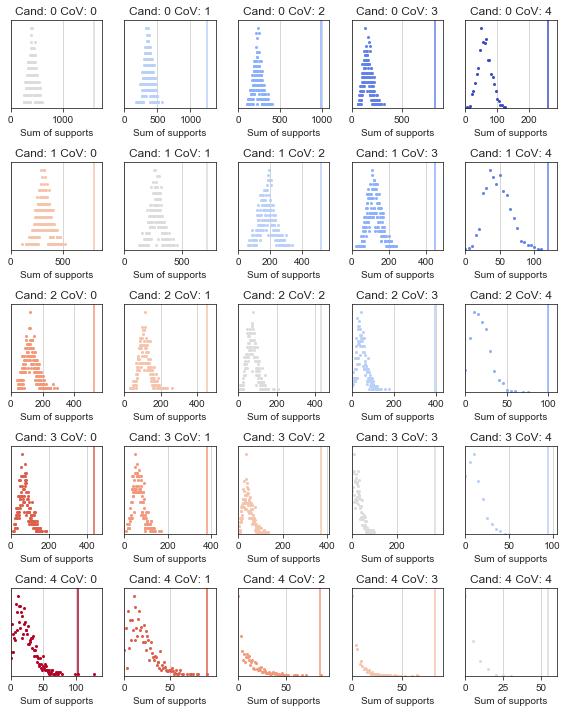

In [83]:
with h5py.File("../web/data/dist_cc.h5", "r") as hf:
    ranks_w = hf["ranks_w"][:]
    cols = hf["cols"][:]
    rows = hf["rows"][:]
    evi_cols = hf["evi_cols"][:]
    evi_rows = hf["evi_rows"][:]
    isdrug_rows = hf["isdrug_rows"][:]

fig, axs = plt.subplots(5,5, figsize=(8,10))
axs = axs.flatten()
i = 0
mask = np.logical_or(isdrug_rows == 1, evi_rows != -2)
for e1 in [0,1,2,3,4]:
    for e2 in [0,1,2,3,4]:
        print(e1, e2)
        empirical_support(axs[i], e1, e2, ranks_w[mask], rows[mask], cols, evi_rows[mask], evi_cols)
        i += 1
plt.tight_layout()
plt.savefig("../web/static/images/docu/empiricals_%s_drug.png" % simtype, dpi=300)

## Example candidate tables


### Q1: Naive search search with pre-clinical evidence

In [106]:
simtype = "cc"

def query1():
    df  = load_df(simtype, 2, None)
    df  = df[df["evidence"] == -2]
    df1 = df[df["is_drug"] == 1][:3]
    df2 = df[df["is_drug"] == 0][:3]
    df  = df1.append(df2)
    return df

df = query1()
df

,inchikey,name,is_drug,evidence,moa,support,lpv_5,lpv_4,lpv_3,top1_inchikey,top2_inchikey,top3_inchikey,top1_name,top2_name,top3_name
0,JFVZFKDSXNQEJW-CQSZACIVSA-N,Tenofovir disoproxil,1,-2,-2,57,1,3,10,JUZYLCPPVHEVSV-UHFFFAOYSA-N,MCGSCOLBFJQGHM-UHFFFAOYSA-N,VRTWBAAJJOHBQU-KMWAZVGDSA-N,Elvitegravir,Abacavir,Ledipasvir
7,VDBGPMJFHCJMOL-UHFFFAOYSA-N,Alamifovir,1,-2,-2,41,0,3,7,MCGSCOLBFJQGHM-UHFFFAOYSA-N,JUZYLCPPVHEVSV-UHFFFAOYSA-N,VRTWBAAJJOHBQU-KMWAZVGDSA-N,Abacavir,Elvitegravir,Ledipasvir
9,VKXWOLCNTHXCLF-UHFFFAOYSA-N,Balapiravir,1,-2,-2,41,0,2,8,MCGSCOLBFJQGHM-UHFFFAOYSA-N,VRTWBAAJJOHBQU-KMWAZVGDSA-N,JNTOCHDNEULJHD-UHFFFAOYSA-N,Abacavir,Ledipasvir,Penciclovir
1,UVIUBXKVDCKKBS-HCZOVWHVSA-N,Chembl3350644,0,-2,-2,49,0,2,10,GLWHPRRGGYLLRV-XLPZGREQSA-N,VRTWBAAJJOHBQU-KMWAZVGDSA-N,CZFFBEXEKNGXKS-UHFFFAOYSA-N,Zidovudine Triphosphate,Ledipasvir,Raltegravir
2,SGNCRBDRAPGGCK-UHFFFAOYSA-N,Ac1L8Rwl,0,-2,-2,46,2,4,4,XXSMGPRMXLTPCZ-UHFFFAOYSA-N,WHTVZRBIWZFKQO-UHFFFAOYSA-N,OVCDSSHSILBFBN-UHFFFAOYSA-N,Hydroxychloroquine,Chloroquine,Amodiaquine
4,VRXFDHAGFYWGHT-UHFFFAOYSA-N,Desethylamodiaquine,0,-2,-2,44,3,3,4,WHTVZRBIWZFKQO-UHFFFAOYSA-N,OVCDSSHSILBFBN-UHFFFAOYSA-N,XEEQGYMUWCZPDN-DOMZBBRYSA-N,Chloroquine,Amodiaquine,Mefloquine


### Q2: Any evidence for Virus Entry and Host factor

In [125]:
def query2():
    df  = load_df(simtype, None, None)
    df1 = load_df(simtype, None, 1)
    df2 = load_df(simtype, None, 2)
    df = df[df["inchikey"].isin(set(df1["inchikey"]).intersection(df2["inchikey"]))]
    df = df[df["evidence"] == -2]
    df1 = df[df["is_drug"] == 1][:3]
    df2 = df[df["is_drug"] == 0][:3]
    df  = df1.append(df2)
    return df

df = query2()
df

,inchikey,name,is_drug,evidence,moa,support,lpv_5,lpv_4,lpv_3,top1_inchikey,top2_inchikey,top3_inchikey,top1_name,top2_name,top3_name
1206,WTHRRGMBUAHGNI-LCYNINFDSA-N,Quinupristin,1,-2,-2,20,0,0,7,KQXDHUJYNAXLNZ-XQSDOZFQSA-N,MQTOSJVFKKJCRP-BICOPXKESA-N,OBMNJSNZOWALQB-NCQNOWPTSA-N,Salinomycin,Azithromycin,Grazoprevir
1773,ACTOXUHEUCPTEW-KWBWCIJSSA-N,Spiramycin,1,-2,-2,18,0,1,6,MQTOSJVFKKJCRP-BICOPXKESA-N,BJNLLBUOHPVGFT-UHFFFAOYSA-N,KQXDHUJYNAXLNZ-XQSDOZFQSA-N,Azithromycin,Teicoplanin,Salinomycin
1811,KVYARXTXGITUCU-UHFFFAOYSA-N,2-Iodobenzylthio Group,1,-2,-2,17,0,2,4,FOQRKFCLRMMKAT-UHFFFAOYSA-N,KCFYEAOKVJSACF-UHFFFAOYSA-N,MGLZGLAFFOMWPB-UHFFFAOYSA-N,Pd144418,Umifenovir,"2-Chlorobenzene-1,4-Diamine"
0,WLEGHUATPVYRSK-UHFFFAOYSA-N,Ac1Oa4Rn,0,-2,-2,86,0,4,34,DOMXUEMWDBAQBQ-UHFFFAOYSA-N,BKUISYCLLXCBJV-CQSZACIVSA-N,CGZOGNUFXMNYEI-UDUHKTKDSA-N,Terbinafine,Chembl2152855,Chebi:125390
14,FBZKQBVUJOMATN-UHFFFAOYSA-N,"Iodinated Benzimidazole, 9A",0,-2,-2,46,0,2,15,JUZYLCPPVHEVSV-UHFFFAOYSA-N,BPBPYQWMFCTCNG-UHFFFAOYSA-N,DOMXUEMWDBAQBQ-UHFFFAOYSA-N,Elvitegravir,PX-12,Terbinafine
36,QDALMVIPZUTVOI-UHFFFAOYSA-N,Ac1Obi1P,0,-2,-2,42,0,2,18,DOMXUEMWDBAQBQ-UHFFFAOYSA-N,FOQRKFCLRMMKAT-UHFFFAOYSA-N,GLYGRBPLZURLDD-UHFFFAOYSA-N,Terbinafine,Pd144418,6-Mercaptopurine Deriv.


### Q3: Mild polypharmacology

In [128]:
def query3():
    df  = load_df(simtype, None, None)
    df3 = load_df(simtype, None, 3)
    df4 = load_df(simtype, None, 4)
    df5 = load_df(simtype, None, 5)
    iks = set(df3["inchikey"]).intersection(df4["inchikey"]).intersection(df5["inchikey"])
    df = df[df["inchikey"].isin(iks)]
    df = df[df["evidence"] == -2]
    df1 = df[df["is_drug"] == 1][:3]
    df2 = df[df["is_drug"] == 0][:3]
    df  = df1.append(df2)
    return df

df = query3()
df

,inchikey,name,is_drug,evidence,moa,support,lpv_5,lpv_4,lpv_3,top1_inchikey,top2_inchikey,top3_inchikey,top1_name,top2_name,top3_name
42,NCLGDOBQAWBXRA-PGRDOPGGSA-N,Telotristat,1,-2,-2,40,0,3,15,BKUISYCLLXCBJV-CQSZACIVSA-N,QPDYBCZNGUJZDK-DNQXCXABSA-N,ONJZYZYZIKTIEG-CFBQITSMSA-N,Chembl2152855,Brilacidin,(3s6s9r10r11s12s13e15e18s21s)-18-{(1e3e7s8s)-9...
263,VMTDLKOWOZYTPX-RZKNNNBGSA-N,Jaspisamide A,1,-2,-2,29,0,0,12,QJJXYPPXXYFBGM-LFZNUXCKSA-N,ANZDZWVXRMQUTQ-HMOSVFKPSA-N,UOLMBKMTFQNDOO-LFIICKCGSA-N,Tacrolimus,Chembl3220761,Chembl3220760
2863,GVEZIHKRYBHEFX-NQQPLRFYSA-N,Cerulenin,1,-2,-2,15,0,2,4,AUZONCFQVSMFAP-UHFFFAOYSA-N,AOCCBINRVIKJHY-UHFFFAOYSA-N,GLVAUDGFNGKCSF-UHFFFAOYSA-N,Disulfiram,Carmofur,Mercaptopurine
0,WLEGHUATPVYRSK-UHFFFAOYSA-N,Ac1Oa4Rn,0,-2,-2,86,0,4,34,DOMXUEMWDBAQBQ-UHFFFAOYSA-N,BKUISYCLLXCBJV-CQSZACIVSA-N,CGZOGNUFXMNYEI-UDUHKTKDSA-N,Terbinafine,Chembl2152855,Chebi:125390
40,KBKZKGBBUGWBJI-UHFFFAOYSA-N,Ac1Oiva2,0,-2,-2,40,0,1,18,DOMXUEMWDBAQBQ-UHFFFAOYSA-N,BKUISYCLLXCBJV-CQSZACIVSA-N,GCWIQUVXWZWCLE-INIZCTEOSA-N,Terbinafine,Chembl2152855,Cpi-0610
43,JLECXGJGBGFQLF-UHFFFAOYSA-N,Chembl237639,0,-2,-2,40,0,2,16,QPDYBCZNGUJZDK-DNQXCXABSA-N,BKUISYCLLXCBJV-CQSZACIVSA-N,BPBPYQWMFCTCNG-UHFFFAOYSA-N,Brilacidin,Chembl2152855,PX-12
